In [1]:
import os
main_dir = os.path.dirname(os.path.dirname(os.getcwd()))
os.chdir(main_dir)

import pyvdirs.dirs as dirs
import sys
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from karras.training.training_loop import learning_rate_schedule
from Images.train_edm2 import img_to_tiny

%load_ext autoreload
%autoreload 2

/home/valeria/anaconda3/envs/SCIDev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

In [ ]:
super_batch_size = 16*32*4
mini_batch_size = 3*16*2*4
print(super_batch_size, mini_batch_size, mini_batch_size/super_batch_size)

2048 384 0.1875


In [4]:
cur_nimg = np.linspace(0, 24.4e6, 500)

## Original exploration

In [4]:
lr_original_params = np.array([learning_rate_schedule(nimg, super_batch_size, 0.0170) for nimg in cur_nimg])
lr_adapted_params = np.array([learning_rate_schedule(nimg, super_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6) for nimg in cur_nimg])

Text(0.5, 0, 'Training time without data selection [hs]')

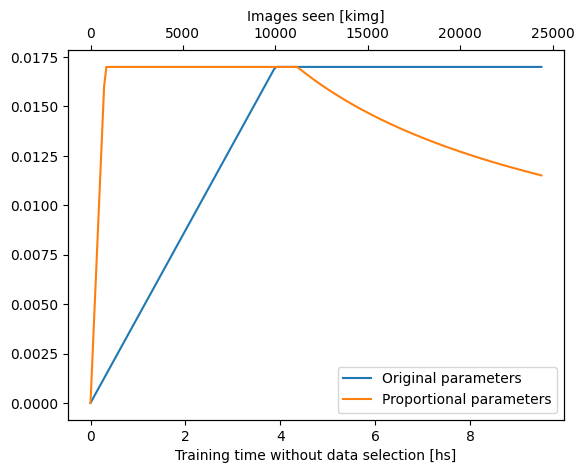

In [5]:
fig, ax = plt.subplots()
ax2 = ax.twiny()
plt.plot(cur_nimg/1e3, lr_original_params, label="Original parameters", linewidth=1.5)
plt.plot(cur_nimg/1e3, lr_adapted_params, label="Proportional parameters")
plt.xlabel("Images seen [kimg]")
plt.ylabel("Learning rate [kimg]")
plt.legend()
ax.set_xlim(np.array(ax2.get_xlim())*1e3*2.87/60/60/2048)
ax.set_xlabel("Training time without data selection [hs]")

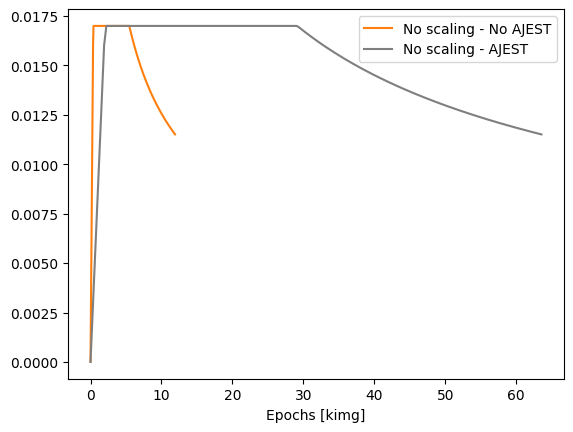

In [6]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/1e3/super_batch_size, lr_adapted_params, color="C1", label="No scaling - No AJEST")
plt.plot(cur_nimg/1e3/mini_batch_size, lr_adapted_params, color="C7", label="No scaling - AJEST")
plt.xlabel("Epochs [kimg]")
plt.legend()

In [5]:
lr_proportional_params = np.array([learning_rate_schedule(nimg, super_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6) for nimg in cur_nimg]) # == lr_adapted_params
lr_proportional_params_ajest = np.array([learning_rate_schedule(nimg, mini_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6,
                                    super_batch_size=super_batch_size) for nimg in cur_nimg])


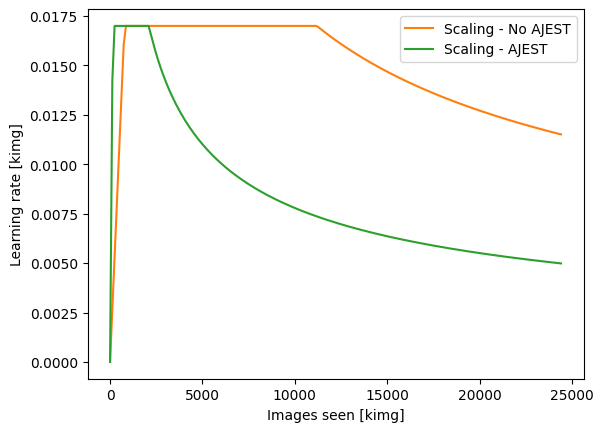

In [8]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/1e3, lr_proportional_params, color="C1", label="Scaling - No AJEST")
plt.plot(cur_nimg/1e3, lr_proportional_params_ajest, color="C2", label="Scaling - AJEST")
plt.xlabel("Images seen [kimg]")
plt.ylabel("Learning rate [kimg]")
plt.legend()

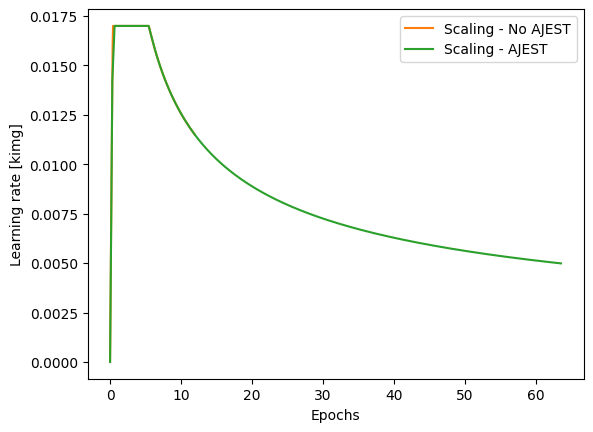

In [15]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/1e3/super_batch_size, lr_proportional_params, color="C1", label="Scaling - No AJEST")
plt.plot(cur_nimg/1e3/mini_batch_size, lr_proportional_params_ajest, color="C2", label="Scaling - AJEST")
plt.xlabel("Epochs")
plt.ylabel("Learning rate [kimg]")
plt.legend()
# plt.xlim((0,10))

In [64]:
batch_size = np.array([*[mini_batch_size]*100,*[super_batch_size]*100])
lr_early_ajest = np.array([learning_rate_schedule(nimg, bs, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/2048,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6,
                                    super_batch_size=2048) for nimg, bs in zip(cur_nimg, batch_size)])
lr_late_ajest = np.array([learning_rate_schedule(nimg, bs, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/2048,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6,
                                    super_batch_size=2048) for nimg, bs in zip(cur_nimg, batch_size[::-1])])

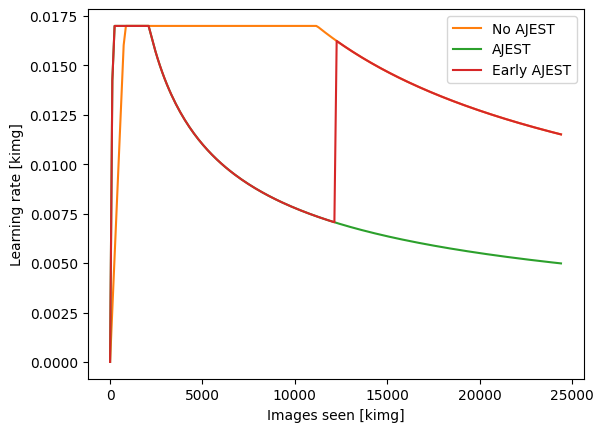

In [ ]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/1e3, lr_proportional_params, color="C1", label="No AJEST")
plt.plot(cur_nimg/1e3, lr_proportional_params_ajest, color="C2", label="AJEST")
plt.plot(cur_nimg/1e3, lr_early_ajest, color="C3", label="Early AJEST")
plt.xlabel("Images seen [kimg]")
plt.ylabel("Learning rate [kimg]")
plt.legend()

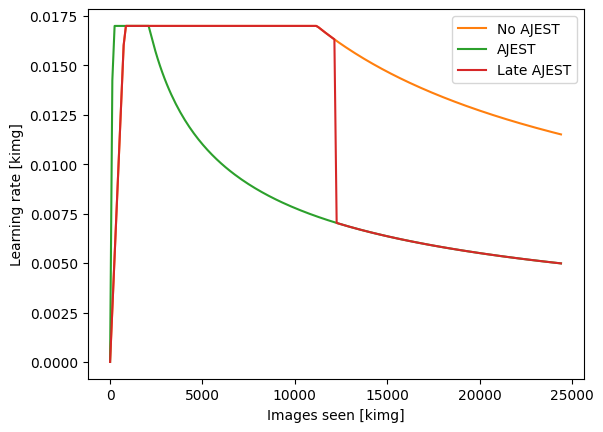

In [65]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/1e3, lr_proportional_params, color="C1", label="No AJEST")
plt.plot(cur_nimg/1e3, lr_proportional_params_ajest, color="C2", label="AJEST")
plt.plot(cur_nimg/1e3, lr_late_ajest, color="C3", label="Late AJEST")
plt.xlabel("Images seen [kimg]")
plt.ylabel("Learning rate [kimg]")
plt.legend()

In [45]:
batch_size = np.array([*[mini_batch_size]*100,*[super_batch_size]*100])

prev_bs = batch_size[0]
diff_lr = 0
lr_early_ajest = []
for nimg, bs in zip(cur_nimg, batch_size):
    if bs != prev_bs:
        lr = learning_rate_schedule(nimg, bs, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6,
                                    super_batch_size=super_batch_size)
        diff_lr = lr - lr_early_ajest[-1]
    lr = learning_rate_schedule(nimg, bs, 0.0170,
                                ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                rampup_Mimg=img_to_tiny(10e6)/1e6,
                                super_batch_size=super_batch_size, diff_lr=diff_lr)
    lr_early_ajest.append(lr)
    prev_bs = bs

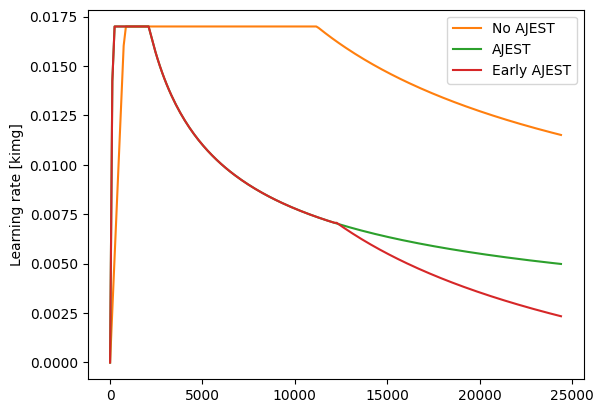

In [48]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/1e3, lr_proportional_params, color="C1", label="No AJEST")
plt.plot(cur_nimg/1e3, lr_proportional_params_ajest, color="C2", label="AJEST")
plt.plot(cur_nimg/1e3, lr_early_ajest, color="C3", label="Early AJEST")
plt.ylabel("Learning rate [kimg]")
plt.legend()

In [61]:
batch_size = np.array([*[mini_batch_size]*100,*[super_batch_size]*100])
curr_nimg_bs = np.array([*[mini_batch_size]*100,
                         *[super_batch_size]*100])

prev_bs = batch_size[0]
diff_nimg = 0
lr_early_ajest = []
for batch_i, (nimg, bs) in enumerate(zip(cur_nimg, batch_size)):
    if bs != prev_bs:
        diff_nimg = (super_batch_size-mini_batch_size)*batch_i
        batch_s = batch_i
    lr = learning_rate_schedule(nimg, bs, 0.0170,
                                ref_batches=img_to_tiny(70e3*super_batch_size)/super_batch_size,
                                rampup_Mimg=img_to_tiny(10e6)/1e6,
                                super_batch_size=super_batch_size, diff_nimg=diff_nimg)
    lr_early_ajest.append(lr)
    prev_bs = bs

Text(0.5, 0, 'Training time without data selection [hs]')

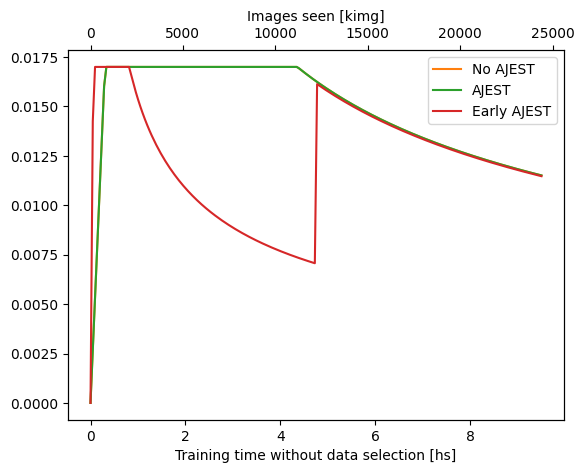

In [60]:
fig, ax = plt.subplots()
ax2 = ax.twiny()
plt.plot(cur_nimg/1e3, lr_adapted_params, color="C1", label="No AJEST")
plt.plot(cur_nimg/1e3, lr_proportional_params, color="C2", label="AJEST")
plt.plot(cur_nimg/1e3, lr_early_ajest, color="C3", label="Early AJEST")
plt.xlabel("Images seen [kimg]")
plt.ylabel("Learning rate [kimg]")
plt.legend()
ax.set_xlim(np.array(ax2.get_xlim())*1e3*2.87/60/60/2048)
ax.set_xlabel("Training time without data selection [hs]")

## New exploration

### Option - Adapted Karras, the right way

```python
# Make it decay faster while selecting data
n_batches = (cur_nimg - diff_nimg) * super_batch_size / (batch_size**2)

# Ramp up according to number of images seen with the super batch size and no data selection
rampup_batches = rampup_Mimg * 1e6 / ref_batch_size

# Decay according to number of batches, regardless of batch size
ref_batches = ref_batches
```

In [101]:
ref_batch_size = 2048
super_batch_size = 16*32*4
mini_batch_size = 3*16*2*4
print("= No AJEST - Original super batch size ==============")
lr_no_ajest = np.array([learning_rate_schedule(nimg, super_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*ref_batch_size)/ref_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6, 
                                    ref_batch_size=ref_batch_size,
                                    verbose=(nimg==cur_nimg[int(len(cur_nimg)/5)])) for nimg in cur_nimg]) # == lr_adapted_params
print("= AJEST - Original super batch size =================")
lr_ajest = np.array([learning_rate_schedule(nimg, mini_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*ref_batch_size)/ref_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6,
                                    super_batch_size=super_batch_size, 
                                    ref_batch_size=ref_batch_size,
                                    verbose=(nimg==cur_nimg[int(len(cur_nimg)/5)])) for nimg in cur_nimg])
super_batch_size_s = super_batch_size / 2
mini_batch_size_s = mini_batch_size / 2
print("= No AJEST - Smaller super batch size ==============")
lr_no_ajest_s = np.array([learning_rate_schedule(nimg, super_batch_size_s, 0.0170,
                                    ref_batches=img_to_tiny(70e3*ref_batch_size)/ref_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6, 
                                    super_batch_size=super_batch_size_s, 
                                    ref_batch_size=ref_batch_size,
                                    verbose=(nimg==cur_nimg[int(len(cur_nimg)/5)])) for nimg in cur_nimg]) # == lr_adapted_params
print("= AJEST - Smaller super batch size =================")
lr_ajest_s = np.array([learning_rate_schedule(nimg, mini_batch_size_s, 0.0170,
                                    ref_batches=img_to_tiny(70e3*ref_batch_size)/ref_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6,
                                    super_batch_size=super_batch_size_s, 
                                    ref_batch_size=ref_batch_size,
                                    verbose=(nimg==cur_nimg[int(len(cur_nimg)/5)])) for nimg in cur_nimg])

= No AJEST - Original super batch size ==============
Original
> N img 4889779.559118236
> Rampup img 780288.0
> Ref batches 5463.0
> Ref batches * batch size > Rampup Nimg True
Final
> N batches 4889779.559118236
> Rampup batches (r) 381.0
> Ref batches (t0) 5463.0
> Ref batches * batch size > Rampup Nimg True
= AJEST - Original super batch size =================
Original
> N img 4889779.559118236
> Rampup img 780288.0
> Ref batches 5463.0
> Ref batches * batch size > Rampup Nimg True
Final
> N batches 4889779.559118236
> Rampup batches (r) 381.0
> Ref batches (t0) 5463.0
> Ref batches * batch size > Rampup Nimg True
= No AJEST - Smaller super batch size ==============
Original
> N img 4889779.559118236
> Rampup img 780288.0
> Ref batches 5463.0
> Ref batches * batch size > Rampup Nimg True
Final
> N batches 4889779.559118236
> Rampup batches (r) 762.0
> Ref batches (t0) 5463.0
> Ref batches * batch size > Rampup Nimg True
= AJEST - Smaller super batch size =================
Original


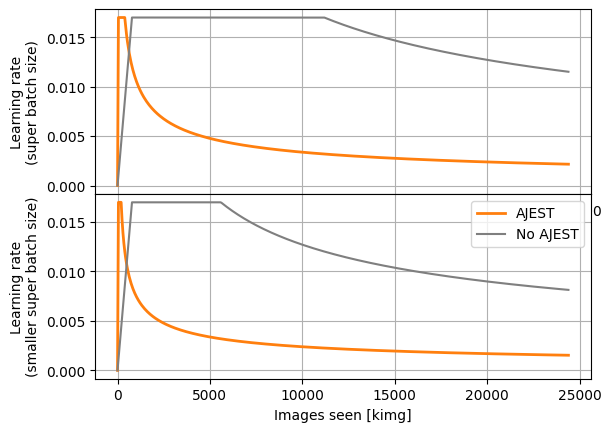

In [102]:
fig, axes = plt.subplots(nrows=2, gridspec_kw=dict(hspace=0))

axes[0].plot(cur_nimg/1e3, lr_ajest, color="C1", label="AJEST", linewidth=2)
axes[0].plot(cur_nimg/1e3, lr_no_ajest, color="C7", label="No AJEST", linewidth=1.5)

axes[1].plot(cur_nimg/1e3, lr_ajest_s, color="C1", label="AJEST", linewidth=2)
axes[1].plot(cur_nimg/1e3, lr_no_ajest_s, color="C7", label="No AJEST", linewidth=1.5)

plt.xlabel("Images seen [kimg]")
plt.legend()
for ax, label in zip(axes, ["", "smaller "]): 
    ax.grid(); ax.set_ylabel("Learning rate\n("+label+"super batch size)")

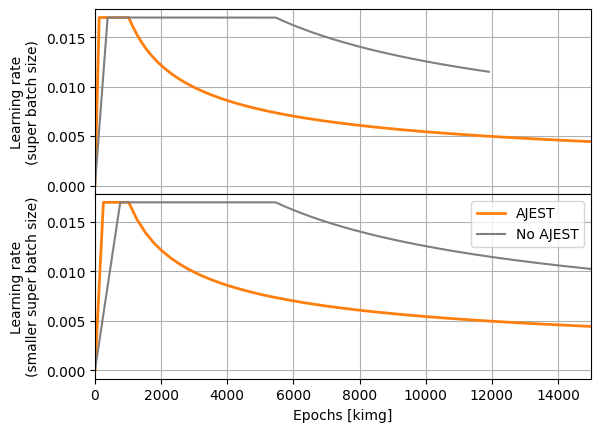

In [103]:
fig, axes = plt.subplots(nrows=2, sharex=True, gridspec_kw=dict(hspace=0))

axes[0].plot(cur_nimg/mini_batch_size, lr_ajest, color="C1", label="AJEST", linewidth=2)
axes[0].plot(cur_nimg/super_batch_size, lr_no_ajest, color="C7", label="No AJEST", linewidth=1.5)

axes[1].plot(cur_nimg/mini_batch_size_s, lr_ajest_s, color="C1", label="AJEST", linewidth=2)
axes[1].plot(cur_nimg/super_batch_size_s, lr_no_ajest_s, color="C7", label="No AJEST", linewidth=1.5)
plt.xlabel("Epochs [kimg]")
plt.legend()
for ax, label in zip(axes, ["", "smaller "]): 
    ax.set_xlim((0,15e3)); ax.grid(); ax.set_ylabel("Learning rate\n("+label+"super batch size)")
plt.show()

### Option - Karras

```python
# Calculate the number of batches
n_batches = (cur_nimg - diff_nimg) / batch_size

# Ramp up adjusting for batch size, so that it depends on the number of images seen
rampup_batches = rampup_Mimg * 1e6 / batch_size # for given batch size

# Decay for the same number of batches regardless of the batch size
ref_batches = ref_batches
```

In [40]:
print("= No AJEST ==============")
lr_no_ajest = np.array([learning_rate_schedule(nimg, super_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6, 
                                    verbose=(nimg==cur_nimg[int(len(cur_nimg)/5)])) for nimg in cur_nimg]) # == lr_adapted_params
print("= AJEST =================")
lr_ajest = np.array([learning_rate_schedule(nimg, mini_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6,
                                    super_batch_size=super_batch_size, 
                                    verbose=(nimg==cur_nimg[int(len(cur_nimg)/5)])) for nimg in cur_nimg])

= No AJEST ==============
Original
> N img 4889779.559118236
> Rampup img 780288.0
> Ref batches 5463.0
> Ref batches * batch size > Rampup Nimg True
Final
> N batches 4889779.559118236
> Rampup batches (r) 381.0
> Ref batches (t0) 5463.0
> Ref batches * batch size > Rampup Nimg True
= AJEST =================
Original
> N img 4889779.559118236
> Rampup img 780288.0
> Ref batches 5463.0
> Ref batches * batch size > Rampup Nimg True
Final
> N batches 4889779.559118236
> Rampup batches (r) 2032.0
> Ref batches (t0) 5463.0
> Ref batches * batch size > Rampup Nimg True


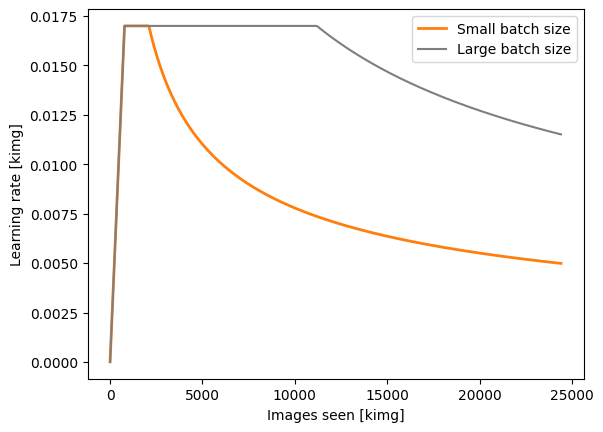

In [46]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/1e3, lr_ajest, color="C1", label="Small batch size", linewidth=2)
plt.plot(cur_nimg/1e3, lr_no_ajest, color="C7", label="Large batch size", linewidth=1.5)
plt.xlabel("Images seen [kimg]")
plt.ylabel("Learning rate [kimg]")
plt.legend()

(0.0, 10000.0)

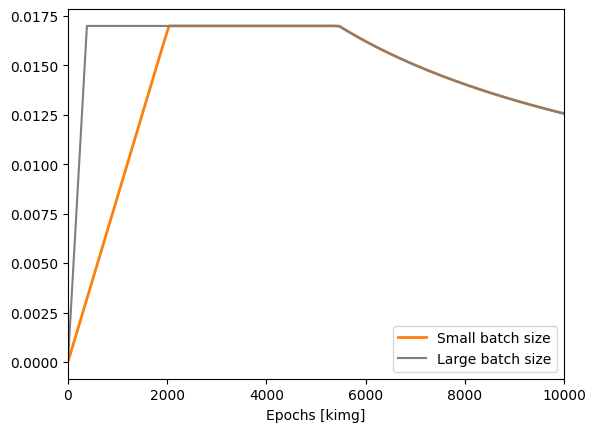

In [44]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/mini_batch_size, lr_ajest, color="C1", label="Small batch size", linewidth=2)
plt.plot(cur_nimg/super_batch_size, lr_no_ajest, color="C7", label="Large batch size")
plt.xlabel("Epochs [kimg]")
plt.legend()
plt.xlim((0,10e3))

### Option - Karras with extra adjustment if selecting data

```python
# Make it decay faster while selecting data
n_batches = (cur_nimg - diff_nimg) * super_batch_size / (batch_size**2)

# Ramp up independently of batch size
rampup_batches = rampup_Mimg * 1e6 / batch_size # for given batch size

# Decay according to the batch size
ref_batches = ref_batches
```

In [37]:
print("= No AJEST ==============")
lr_no_ajest = np.array([learning_rate_schedule(nimg, super_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6, 
                                    verbose=(nimg==cur_nimg[int(len(cur_nimg)/5)])) for nimg in cur_nimg]) # == lr_adapted_params
print("= AJEST =================")
lr_ajest = np.array([learning_rate_schedule(nimg, mini_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6,
                                    super_batch_size=super_batch_size, 
                                    verbose=(nimg==cur_nimg[int(len(cur_nimg)/5)])) for nimg in cur_nimg])

= No AJEST ==============
Original
> N img 4889779.559118236
> Rampup img 780288.0
> Ref batches 5463.0
> Ref batches * batch size > Rampup Nimg True
Final
> N batches 4889779.559118236
> Rampup batches (r) 381.0
> Ref batches (t0) 5463.0
> Ref batches * batch size > Rampup Nimg True
= AJEST =================
Original
> N img 4889779.559118236
> Rampup img 780288.0
> Ref batches 5463.0
> Ref batches * batch size > Rampup Nimg True
Final
> N batches 4889779.559118236
> Rampup batches (r) 2032.0
> Ref batches (t0) 5463.0
> Ref batches * batch size > Rampup Nimg True


Text(0.5, 0, 'Training time without data selection [hs]')

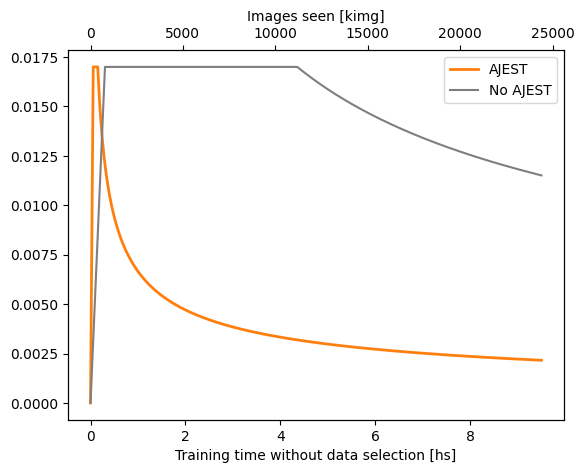

In [38]:
fig, ax = plt.subplots()
ax2 = ax.twiny()
plt.plot(cur_nimg/1e3, lr_ajest, color="C1", label="AJEST", linewidth=2)
plt.plot(cur_nimg/1e3, lr_no_ajest, color="C7", label="No AJEST", linewidth=1.5)
plt.xlabel("Images seen [kimg]")
plt.ylabel("Learning rate [kimg]")
plt.legend()
ax.set_xlim(np.array(ax2.get_xlim())*1e3*2.87/60/60/2048)
ax.set_xlabel("Training time without data selection [hs]")

(0.0, 10000.0)

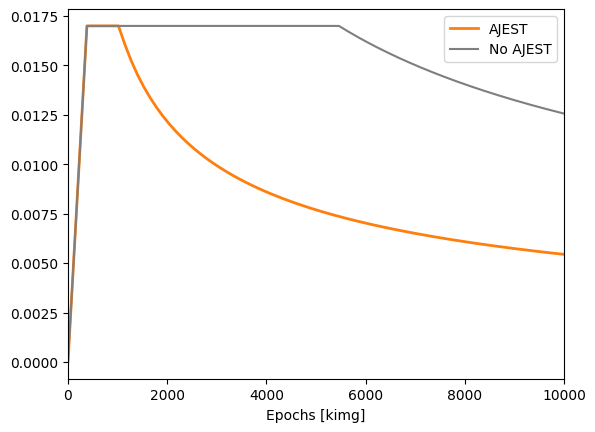

In [39]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/mini_batch_size, lr_ajest, color="C1", label="AJEST", linewidth=2)
plt.plot(cur_nimg/super_batch_size, lr_no_ajest, color="C7", label="No AJEST")
plt.xlabel("Epochs [kimg]")
plt.legend()
plt.xlim((0,10e3))

### Option

```python
# Make it decay faster while selecting data
n_batches = (cur_nimg - diff_nimg) * super_batch_size / (batch_size**2)

# Ramp up according to the number of images seen by a model with the original batch size
rampup_batches = rampup_Mimg * 1e6 / super_batch_size # for given batch size

# Decay according to the number of batches seen by a model with the original batch size (?)
ref_batches = ref_batches
```

In [31]:
print("= No AJEST ==============")
lr_no_ajest = np.array([learning_rate_schedule(nimg, super_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6, 
                                    verbose=(nimg==cur_nimg[int(len(cur_nimg)/5)])) for nimg in cur_nimg]) # == lr_adapted_params
print("= AJEST =================")
lr_ajest = np.array([learning_rate_schedule(nimg, mini_batch_size, 0.0170,
                                    ref_batches=img_to_tiny(70e3*2048)/super_batch_size,
                                    rampup_Mimg=img_to_tiny(10e6)/1e6,
                                    super_batch_size=super_batch_size, 
                                    verbose=(nimg==cur_nimg[int(len(cur_nimg)/5)])) for nimg in cur_nimg])

= No AJEST ==============
Original
> N img 4889779.559118236
> Rampup img 780288.0
> Ref batches 5463.0
> Ref batches * batch size > Rampup Nimg True
Final
> N batches 4889779.559118236
> Rampup batches (r) 381.0
> Ref batches (t0) 5463.0
> Ref batches * batch size > Rampup Nimg True
= AJEST =================
Original
> N img 4889779.559118236
> Rampup img 780288.0
> Ref batches 5463.0
> Ref batches * batch size > Rampup Nimg True
Final
> N batches 4889779.559118236
> Rampup batches (r) 381.0
> Ref batches (t0) 5463.0
> Ref batches * batch size > Rampup Nimg True


Text(0.5, 0, 'Training time without data selection [hs]')

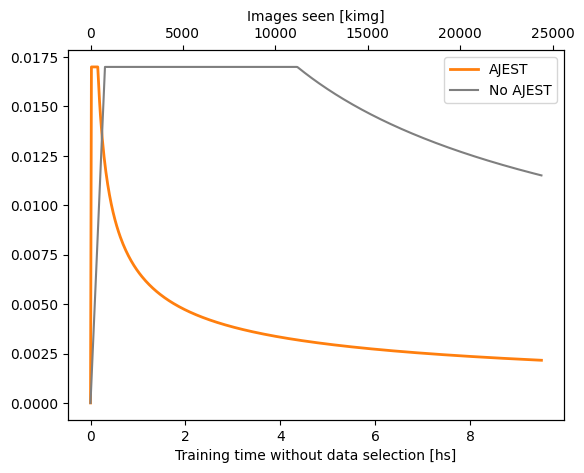

In [32]:
fig, ax = plt.subplots()
ax2 = ax.twiny()
plt.plot(cur_nimg/1e3, lr_ajest, color="C1", label="AJEST", linewidth=2)
plt.plot(cur_nimg/1e3, lr_no_ajest, color="C7", label="No AJEST", linewidth=1.5)
plt.xlabel("Images seen [kimg]")
plt.ylabel("Learning rate [kimg]")
plt.legend()
ax.set_xlim(np.array(ax2.get_xlim())*1e3*2.87/60/60/2048)
ax.set_xlabel("Training time without data selection [hs]")

(0.0, 10000.0)

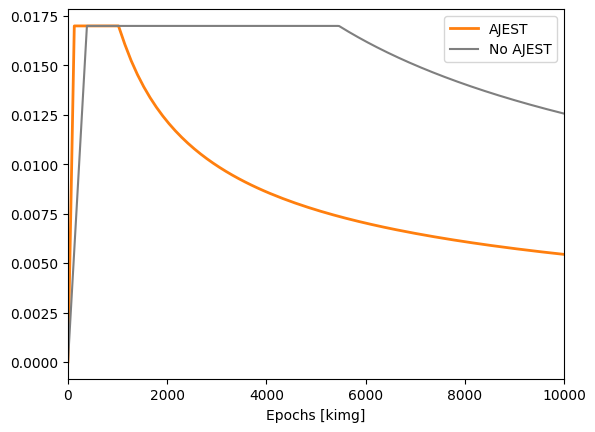

In [33]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/mini_batch_size, lr_ajest, color="C1", label="AJEST", linewidth=2)
plt.plot(cur_nimg/super_batch_size, lr_no_ajest, color="C7", label="No AJEST")
plt.xlabel("Epochs [kimg]")
plt.legend()
plt.xlim((0,10e3))

Text(0.5, 0, 'Training time without data selection [hs]')

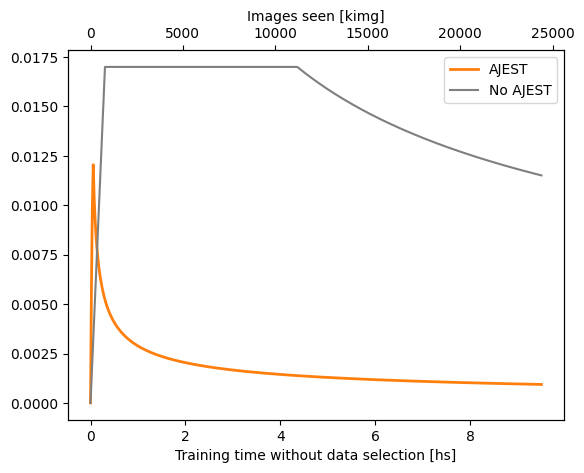

In [11]:
fig, ax = plt.subplots()
ax2 = ax.twiny()
plt.plot(cur_nimg/1e3, lr_ajest, color="C1", label="AJEST", linewidth=2)
plt.plot(cur_nimg/1e3, lr_no_ajest, color="C7", label="No AJEST", linewidth=1.5)
plt.xlabel("Images seen [kimg]")
plt.ylabel("Learning rate [kimg]")
plt.legend()
ax.set_xlim(np.array(ax2.get_xlim())*1e3*2.87/60/60/2048)
ax.set_xlabel("Training time without data selection [hs]")

(0.0, 10000.0)

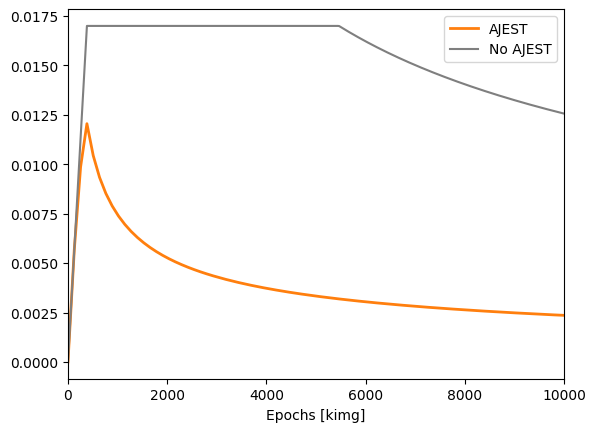

In [12]:
fig, ax = plt.subplots()
plt.plot(cur_nimg/mini_batch_size, lr_ajest, color="C1", label="AJEST", linewidth=2)
plt.plot(cur_nimg/super_batch_size, lr_no_ajest, color="C7", label="No AJEST")
plt.xlabel("Epochs [kimg]")
plt.legend()
plt.xlim((0,10e3))